# Upwelling Detection Using EfficientNet Model

**Packages Explanation**


---


* **pandas**: pandas is a popular library used for data manipulation and analysis. It offers data structures and operations for manipulating numerical tables and time series.

* **Path**: Pathlib is a Python 3.4+ library for handling filesystem paths in a way that is more intuitive and efficient than traditional methods.

* **xarray**: xarray is a Python package that makes working with labelled multi-dimensional arrays simple, efficient, and fun! It is particularly tailored to working with netCDF files, which you often encounter in the atmospheric and oceanographic sciences.

* **numpy**: numpy is a core library for scientific computing in Python. It provides a high-performance multidimensional array object, and tools for working with these arrays.

* **calendar**: The Calendar module in Python provides functions for working with dates and their respective calendars.

* **os.path**: a submodule in the Python os module, and it is used for common pathname manipulations.

* **relativedelta**: It allows more flexibility with handling dates by allowing to calculate differences, which are not supported in standard datetime.timedelta.

* **tensorflow**: tensorflow is a free and open-source software library for machine learning and artificial intelligence.

* **SMOTE**: SMOTE stands for Synthetic Minority Over-sampling Technique. It is an over-sampling method. What it does is, it creates synthetic (not duplicate) samples of the minority class.

* **train_test_split**: It helps to split the data into random train and test subsets.

* **EfficientNetB0**: The CNN model we are going to use in this notebook
Input, Dense, Masking: These are specific layers used in creating neural networks models. Input defines the input shape for the models. Dense is the regular deeply connected neural network layer. Masking is a layer that masks a sequence by using a mask value to skip timesteps.

* **Model**: This is a class from Keras that is used to instantiate a Model, which is a group of layers.

* **TqdmCallback**: TqdmCallback is a callback function in Keras used to display a progress bar during model training.

**Tutorials / Videos for Image Classification**

* [Tensorflow Image Classification](https://www.tensorflow.org/tutorials/images/classification)
* [Neural Network](https://www.youtube.com/watch?v=aircAruvnKk&t=1004s)
* [RNN Model Tutorial](https://www.youtube.com/watch?v=lWkFhVq9-nc)
* [Efficientnet (CNN) Paper walkthrough](https://www.youtube.com/watch?v=_OZsGQHB41s&t=513s)

In [1]:
import pandas as pd
from pathlib import Path
import xarray as xr
import numpy as np
import calendar
import os.path
from dateutil.relativedelta import relativedelta
import tensorflow as tf

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input, Dense, Masking
from tensorflow.keras.models import Model
from tqdm.keras import TqdmCallback

2023-07-18 17:27:46.749046: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-18 17:27:46.799876: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-18 17:27:46.800975: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-18 17:27:47.586367: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Data Selection

We are using the SST data from 2020-01 to 2023-05 for our training, this dataset contains **hourly data**, and has longitude ranges from 0 to 359.8 and latitude ranges from 90 to -90. Since latitude is ranked in descending order, we should keep in mind our slicing for latitude also need to be in descending order. In order to achieve models with better performance, please feel free to use larger datasets for trainings!

Here is a simple visualization for a file stands for 2020-05's SST data.

In [2]:
ds = xr.open_dataset('/home/jovyan/shared/data_sst/202005_sea_surface_temperature.nc')
ds

<xarray.Dataset>
Dimensions:                  (lon: 1440, lat: 721, time0: 744)
Coordinates:
  * lon                      (lon) float32 0.0 0.25 0.5 ... 359.2 359.5 359.8
  * lat                      (lat) float32 90.0 89.75 89.5 ... -89.75 -90.0
  * time0                    (time0) datetime64[ns] 2020-05-01 ... 2020-05-31...
Data variables:
    sea_surface_temperature  (time0, lat, lon) float32 ...
Attributes:
    source:       Reanalysis
    institution:  ECMWF
    title:        ERA5 forecasts

Here is the chunk of doing the slicing for our data. Instead of having hourly data, we need daily data for our task, thus we take 9AM's data for each day in our dataset. The resullt of printing `sst_data.shape` is `(1218, 101, 41, 1)`, here is the explanation:
* **1218** indicates we have 1218 data samples here, corresponding to the 31 days in our month.
* **101, 41**: The number of data points in latitude and longitude.
* **1**: The channel number of our data. In conventional image classification task, there will be 3 channels (red, green, blue). In our case, sst takes only one channel.


In [4]:
# Specify your longitude and latitude range
lats = slice(25, 0)
lons = slice(70, 80)

# Initialize a list to store the data
data_list = []

# Iterate over the years and months
start_date = pd.to_datetime('2020-01-01')
end_date = pd.to_datetime('2023-5-31')

curr_date = start_date
while curr_date <= end_date:
    year = curr_date.year
    month = curr_date.month

    # Get the number of days in the month
    _, num_days = calendar.monthrange(year, month)

    # Construct the file path
    file_path = f'/home/jovyan/shared/data_sst/{year}{month:02d}_sea_surface_temperature.nc'

    # Check if the file exists
    if not os.path.exists(file_path):
        print(f'File not found: {file_path}. Skipping this month.')
        curr_date += relativedelta(months=1)
        continue

    # Open the dataset
    ds = xr.open_dataset(file_path)

    # Select the time points
    time_points = pd.date_range(start=f'{year}-{month:02d}-01T09:00:00', end=f'{year}-{month:02d}-{num_days}T09:00:00', freq='D')
    ds_selected_time = ds.sel(time0=time_points, method='nearest')

    # Select the longitude and latitude
    ds_selected = ds_selected_time.sel(lon=lons, lat=lats)

    # Get the sea_surface_temperature values
    sst_data = ds_selected['sea_surface_temperature'].values
    sst_data = np.expand_dims(sst_data, axis=-1)

    # Append the data to the list
    data_list.append(sst_data)

    # Move to the next month
    curr_date += relativedelta(months=1)

    # Print a message
    print(f'Successfully processed data for: {year}-{month:02d}')

# Concatenate all the data
sst_data = np.concatenate(data_list, axis=0)

print(sst_data.shape)

Successfully processed data for: 2020-01
File not found: /home/jovyan/shared/data_sst/202002_sea_surface_temperature.nc. Skipping this month.
Successfully processed data for: 2020-03
Successfully processed data for: 2020-04
Successfully processed data for: 2020-05
Successfully processed data for: 2020-06
Successfully processed data for: 2020-07
Successfully processed data for: 2020-08
Successfully processed data for: 2020-09
Successfully processed data for: 2020-10
Successfully processed data for: 2020-11
Successfully processed data for: 2020-12
Successfully processed data for: 2021-01
Successfully processed data for: 2021-02
Successfully processed data for: 2021-03
Successfully processed data for: 2021-04
Successfully processed data for: 2021-05
Successfully processed data for: 2021-06
Successfully processed data for: 2021-07
Successfully processed data for: 2021-08
Successfully processed data for: 2021-09
Successfully processed data for: 2021-10
Successfully processed data for: 2021-

**Sample Visualization**

This chunk of code selects a specific day from the dataset (in this case, the index is set to 0, referring to the first day) and retrieves the sea surface temperature data for that day. It then removes the last dimension of the data in order to plot in 2D.

In order to ensure the image is represented correctly, it flips the data along the first axis because matplotlib places the (0,0) point at the top left by default, while our data is ordered from North to South, and West to East.

Then, it retrieves the corresponding latitude and longitude values. Next, it creates a new figure and plots the data for the selected day onto the image, using the 'viridis' color map. The origin='lower' argument ensures that the origin of the image is at the bottom left, and the extent parameter sets the bounds of the image.

A colorbar is added, indicating the range of sea surface temperature values.

Finally, it sets the labels for the x-axis and y-axis to be the longitude and latitude, respectively.

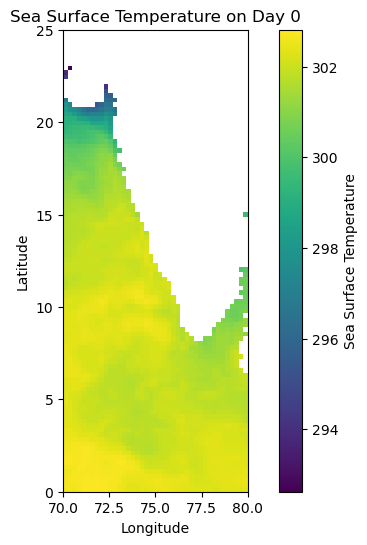

In [6]:
from matplotlib import pyplot as plt
# Choose one day of data
day_index = 0  # choose the day
day_data = sst_data[day_index]

# Remove the last dimension
day_data = np.squeeze(day_data)

# Flip the data along the first axis
day_data = np.flipud(day_data)

# Get the lat and lon values
lat_values = ds_selected.lat.values
lon_values = ds_selected.lon.values

# Create the figure
plt.figure(figsize=(8, 6))

# Plot the data of the day
plt.imshow(day_data, cmap='viridis', origin='lower', extent=[lon_values.min(), lon_values.max(), lat_values.min(), lat_values.max()])

# Add a colorbar
plt.colorbar(label='Sea Surface Temperature')

# Set the labels for the x and y axes
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Set the title
plt.title('Sea Surface Temperature on Day {}'.format(day_index))

# Show the plot
plt.show()

# Labels Processing

This chunk processes Sea Surface Temperature (SST) difference datasets from the years 2020 to 2023 (inclusive), stored as .nc files in the specified directory. The datasets are processed on a monthly basis.

For each file (year-month pair):

* The existence of the file is checked. If the file doesn't exist, the file is skipped.

* The dataset is loaded and converted to a pandas DataFrame.

* The 'time' column (which is an index) is converted to a date-only format and then reset, making 'time' an explicit column in the DataFrame.

* An 'entry_id' column is added, which enumerates each entry within each date.

* The DataFrame is then filtered for rows where 'entry_id' is either 22 or 23.

* A new column 'label' is created: if the 'SST_Diff' value is less than a specified threshold (-1 in this case), the label is set to 1; otherwise, it's set to 0.

* Labels are then aggregated by 'time': if all 'labels' within a group (a specific date) are 1, the group_label is set to 1, else it's set to 0.

These group_labels are collected and appended to the 'all_labels' Series.

At the end, the script prints out the total number of group labels gathered, indicating the number of date groups processed. Note that the process stops after May 2023.

In [7]:
start_year = 2020
end_year = 2023

# List to store all group labels
all_labels = pd.Series(dtype=int)

# Process each year
for year in range(start_year, end_year + 1):
    # Process each month
    for month in range(1, 13):
        if year == 2023 and month > 5:
            break
        file_name = f"/home/jovyan/shared/SST_Diff/{year}{month:02d}_sst_diff.nc"
        if not Path(file_name).exists():
            print(f"File {file_name} does not exist, skipping...")
            continue
        print(f"Processing file {file_name}...")

        # Open the dataset and convert it to a pandas DataFrame
        temp = xr.open_dataset(file_name)
        temp_df = temp.to_dataframe()

        # Convert the 'time' column to date only format
        temp_df.index = pd.to_datetime(temp_df.index).date

        # Reset index to create 'time' column
        temp_df = temp_df.reset_index()

        # Create a new column 'entry_id' which enumerates each entry within each date
        temp_df['entry_id'] = temp_df.groupby('time').cumcount()

        # Filter dataframe for rows where 'entry_id' is 22 and 23, and create a copy
        filtered_df = temp_df[temp_df['entry_id'].isin([22,23])].copy()

        # Create a label column - set to 1 if SST_Diff < threshold, else set to 0
        threshold = -1
        filtered_df.loc[:, 'label'] = np.where(filtered_df['SST_Diff'] < threshold, 1, 0)

        # Group by 'time' and check if all 'label' in a group is 1, if so, set group_label to 1, else 0
        group_labels = filtered_df.groupby('time')['label'].apply(lambda x: 1 if x.sum() == 2 else 0)

        # Append the group_labels to all_labels
        all_labels = pd.concat([all_labels, group_labels])
print(all_labels.shape)

Processing file /home/jovyan/shared/SST_Diff/202001_sst_diff.nc...
File /home/jovyan/shared/SST_Diff/202002_sst_diff.nc does not exist, skipping...
Processing file /home/jovyan/shared/SST_Diff/202003_sst_diff.nc...
Processing file /home/jovyan/shared/SST_Diff/202004_sst_diff.nc...
Processing file /home/jovyan/shared/SST_Diff/202005_sst_diff.nc...
Processing file /home/jovyan/shared/SST_Diff/202006_sst_diff.nc...
Processing file /home/jovyan/shared/SST_Diff/202007_sst_diff.nc...
Processing file /home/jovyan/shared/SST_Diff/202008_sst_diff.nc...
Processing file /home/jovyan/shared/SST_Diff/202009_sst_diff.nc...
Processing file /home/jovyan/shared/SST_Diff/202010_sst_diff.nc...
Processing file /home/jovyan/shared/SST_Diff/202011_sst_diff.nc...
Processing file /home/jovyan/shared/SST_Diff/202012_sst_diff.nc...
Processing file /home/jovyan/shared/SST_Diff/202101_sst_diff.nc...
Processing file /home/jovyan/shared/SST_Diff/202102_sst_diff.nc...
Processing file /home/jovyan/shared/SST_Diff/202

This line of code reshapes the all_labels pandas Series into a **one-dimensional numpy array**. The values attribute of the pandas Series is used to obtain the data in the form of a numpy array, and the ravel() function is then applied to this array to flatten it.

In [9]:
all_labels_reshaped = all_labels.values.ravel()

This chunk performs a series of transformations on each element (day_data) in a list or array of Sea Surface Temperature (SST) data (sst_data), and stores the processed data in a new list.

For each day_data:

* The data is first "squeezed" using **np.squeeze()**, which removes dimensions of size one from the shape of the data.

* The data is then flipped upside down using **np.flipud()** to ensure that the data orientation matches the desired reference system.

* The mean of the data (ignoring NaN values) is calculated using **np.nanmean()** and stored in sst_data2.

* The mean (sst_data2) is subtracted from the original data to create a **zero-mean** version of the data, which is stored in sst_data3.

This zero-mean data is then appended to the processed_data_list.

At the end of the script, processed_data_list is converted into a numpy array (processed_data). This array consists of processed SST data, with each element representing zero-mean, flipped version of the original SST data corresponding to a specific day.

In [8]:
processed_data_list = []

for day_data in sst_data:
    day_data = np.squeeze(day_data)

    day_data = np.flipud(day_data)

    sst_data2 = np.nanmean(day_data)

    sst_data3 = day_data - sst_data2

    processed_data_list.append(sst_data3)

processed_data = np.array(processed_data_list)

Since we cannot pass inputs with NaN values to our model, we convert those NaN values to 0, then we will use **masking** in our model to ignore those 0s

In [10]:
# Fill NaN with 0
sst_data = np.nan_to_num(processed_data, nan=0.0)

This chunk manipulates the SST (Sea Surface Temperature) data and the labels for use in a machine learning model:

* An additional dimension (a channel dimension typically required by deep learning models) is added to the SST data using **np.expand_dims()**.

* The multidimensional SST data is then flattened into a 2D array using reshape(), which is a necessary preprocessing step for the SMOTE algorithm.

* **Synthetic Minority Over-sampling Technique (SMOTE)** is applied to the flattened SST data and the corresponding labels. This technique is used to tackle the issue of **imbalanced** datasets by generating synthetic samples of the **minority class** (In this case, data with label of 1). The SMOTE algorithm is initialized with a specific random state to ensure reproducibility of the results.

The resampled SST data is reshaped back to its original shape using reshape(), so it can be used in the subsequent processing or machine learning models. This data now has balanced classes, which could potentially improve the performance of the machine learning models trained on this data.

In [11]:
# Add a channel dimension
sst_data = np.expand_dims(sst_data, axis=-1)

# Flatten the data for SMOTE
sst_data_flat = sst_data.reshape(sst_data.shape[0], -1)

# Apply SMOTE
smote = SMOTE(random_state=42)
sst_data_res, labels_res = smote.fit_resample(sst_data_flat, all_labels_reshaped)

# Reshape the data to original shape
sst_data_res = sst_data_res.reshape((-1, processed_data.shape[1], processed_data.shape[2], 1))

This line of code is responsible for splitting the resampled SST (Sea Surface Temperature) data and the corresponding labels into **training** and **testing** sets. It uses the train_test_split function from Scikit-Learn, a common function used for this purpose in machine learning. The test_size parameter is set to 0.2, which means that 20% of the data is reserved for the test set, and the remaining 80% is used for the training set. The random_state parameter is set to 42 to ensure that the data is shuffled in the same way every time the code is run, which ensures reproducibility of the results.

In [13]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(sst_data_res, labels_res, test_size=0.2, random_state=42)

# Model Definition

This line of code defines the base of a machine learning model using the **EfficientNetB0 architecture**, which is part of the Keras Applications module and is a popular choice for image-related tasks.

Here's a breakdown of the parameters:

* `include_top=False` means that the final layer of the model, which is typically responsible for class prediction in the pre-trained version of the model, is not included. This allows a new top layer, appropriate for the current task, to be added later.

* `weights=None` indicates that the model will be initialized without pre-trained weights. This means the model will be trained from scratch. This is because the model was trained on the ImageNet dataset (a dataset of natural objects), thus it's not suitbale for us to obtain those weights for our remote-sensing data which is quite different from natural objects.

* input_shape=(processed_data.shape[1], processed_data.shape[2], 1) sets the shape of the input data that the model will receive. In this case, the input shape matches the dimensions of the SST data, with an additional channel dimension.

In [14]:
# Define the model
base_model = EfficientNetB0(include_top=False, weights=None, input_shape=(processed_data.shape[1], processed_data.shape[2], 1))

This section of code customizes the base EfficientNetB0 model for a specific task by **adding a new top layer** to it.

* The base model's output is first taken and passed through a **GlobalAveragePooling2D layer**, which performs spatial average pooling operation, reducing the spatial dimensions (height and width) of input feature map while preserving the depth. This operation helps to reduce the number of parameters and computation in the network, and hence to also control overfitting.

* **A fully connected (Dense) layer** of 1024 units with ReLU (Rectified Linear Unit) activation function is added next. This layer can learn complex patterns from the pooled features.

* Finally, **a logistic layer**, which is another Dense layer with a single unit and a sigmoid activation function, is added. This layer serves as the output layer of the model and outputs the final prediction. The sigmoid function squishes the output values between 0 and 1, which can be treated as a probability for binary classification tasks.

The Keras Model class is then used to define the complete model, taking the base model's input as its input and the newly added logistic layer's output as its output.

In [15]:
# Add a global spatial average pooling layer
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# Let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# And a logistic layer
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

This chunk performs the necessary steps to train and evaluate the previously defined deep learning model:

* The model is compiled with the '**Adam'** optimizer, a commonly used optimizer that adjusts the learning rate adaptively for different parameters. The loss function is set as 'binary_crossentropy', which is suitable for binary classification tasks. The metric used for model evaluation during training is accuracy.

* A **TqdmCallback** is defined to display a progress bar during model training.

* The model is then trained for **50 epochs** using the fit method. The training data (X_train, y_train) and the TqdmCallback are passed as arguments. The verbose parameter is set to 0, which means no training information will be printed to the console, but the progress is shown by TqdmCallback.

* After training, the model's performance is evaluated on the test data (X_test, y_test) using the evaluate method. The method returns the final loss and accuracy on the test data.

Finally, the accuracy of the model on the test data is printed to the console. This provides an indication of how well the model will likely perform on unseen data, assuming that the test data is a representative sample.

In [16]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

tqdm_callback = TqdmCallback(verbose=1)

# Train the model
model.fit(X_train, y_train, epochs=50, verbose=0, callbacks=[tqdm_callback])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Accuracy: {accuracy}")

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

14/14 [==============================] - 2s 63ms/step - loss: 0.0588 - accuracy: 0.9888
Accuracy: 0.9888142943382263


# Detection Results Displays
After we obtained the model, we can use it to detect upwelling on our dataset. Here we choose the dataset from 2015-01 to 2023-05, notice we have some months where the data is missing, so we skip those months. The output dataframe will have three columns: **time**, **actual_val**, and **predicted_val**. The actual val will be either 0 or 1, and the predicted_val is a float number between 0 and 1 indicating the likelihood of having upwelling.

In [61]:
# Start date
start_date = pd.to_datetime('2020-01-01')
end_date = pd.to_datetime('2023-5-31')
excluded_months = ['198304', '198802', '199209', '199702', '200111', '200604', '201102', '201506', '202002']

# Initialize an empty list to store the rows of the DataFrame
data = []

# Initialize the current index of sst_data and all_labels_reshaped
curr_index = 0

# Iterate over the dates
curr_date = start_date
while curr_date <= end_date:
    year_month = curr_date.strftime('%Y%m')
    if year_month in excluded_months:
        _, num_days = calendar.monthrange(curr_date.year, curr_date.month)
        curr_index += num_days
        curr_date += relativedelta(months=1)
        continue
    _, num_days = calendar.monthrange(curr_date.year, curr_date.month)
    for _ in range(num_days):
        # Check if the current index is out of bounds
        if curr_index >= len(all_labels_reshaped):
            break
        # Get the actual value
        actual_val = all_labels_reshaped[curr_index]

        # Get the prediction
        day_data = processed_data[curr_index]  # Get the data from processed_data
        day_data = np.nan_to_num(day_data, nan=0.0)  # Replace NaN with 0
        day_data = np.expand_dims(day_data, axis=(0, -1))  # Add a new dimension for the batch and channel

        prediction = model.predict(day_data)

        # Append the data to the list
        data.append({'time': curr_date, 'actual_val': actual_val, 'predicted_val': prediction})

        # Increase the current index and the current date
        curr_index += 1
        curr_date += pd.DateOffset(days=1)

    # Exit the loop if the current index is out of bounds
    if curr_index >= len(all_labels_reshaped):
        break

# Create the DataFrame
df = pd.DataFrame(data)

# Check the DataFrame
print(df)


1/1 [==============================] - 0s 24ms/step
           time  actual_val      predicted_val
0    2020-01-01           0   [[5.385395e-07]]
1    2020-01-02           0  [[2.3130782e-07]]
2    2020-01-03           0   [[3.872007e-07]]
3    2020-01-04           0  [[1.5298696e-06]]
4    2020-01-05           0   [[7.999084e-07]]
...         ...         ...                ...
1184 2023-04-28           0  [[5.0074805e-06]]
1185 2023-04-29           0   [[5.683551e-06]]
1186 2023-04-30           0  [[1.1370157e-06]]
1187 2023-05-01           0  [[3.9128504e-06]]
1188 2023-05-02           0   [[4.417688e-08]]

[1189 rows x 3 columns]


Let's set a threshold of 0.5 and see the results.

In [62]:
print(len(df[(df['actual_val'] == 0) & (df['predicted_val'] > 0.5)]))
print(len(df[(df['actual_val'] == 0)]))
print(len(df[(df['actual_val'] == 1) & (df['predicted_val'] > 0.5)]))
print(len(df[(df['actual_val'] == 1)]))

5
1088
101
101


Make a histogram visualization to observe the whole distribution.

/tmp/ipykernel_194/2772321865.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(group0, bins=20, kde=False, norm_hist=True, label='Actual_val 0')
/tmp/ipykernel_194/2772321865.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(group1, bins=20, kde=False, norm_hist=True, label='Actual_val 1'

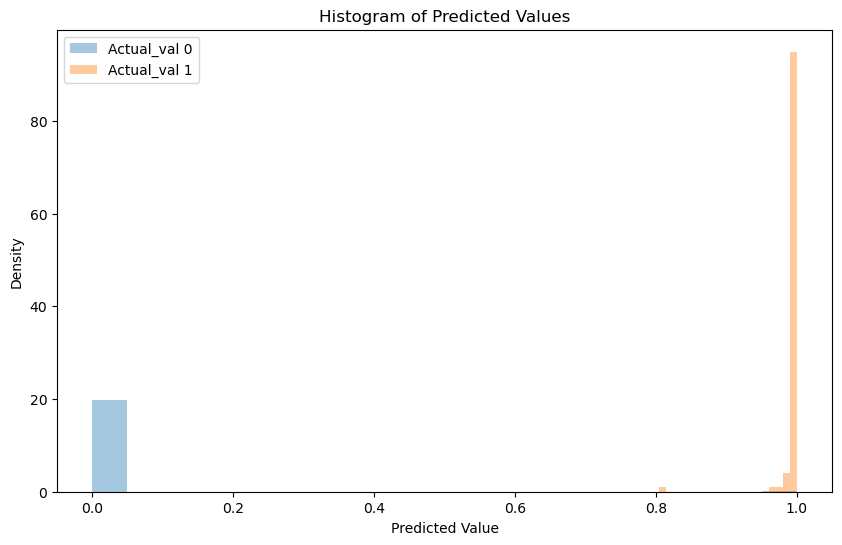

In [63]:
import seaborn as sns

# Convert 'predicted_val' to float
df['predicted_val'] = df['predicted_val'].apply(lambda x: float(x[0]))

# Separate the data into two groups based on 'actual_val'
group0 = df[df['actual_val'] == 0]['predicted_val']
group1 = df[df['actual_val'] == 1]['predicted_val']

# Create the histogram plot
plt.figure(figsize=(10, 6))
sns.distplot(group0, bins=20, kde=False, norm_hist=True, label='Actual_val 0')
sns.distplot(group1, bins=20, kde=False, norm_hist=True, label='Actual_val 1')

# Set the labels and title
plt.xlabel('Predicted Value')
plt.ylabel('Density')
plt.title('Histogram of Predicted Values')
plt.legend()

# Show the plot
plt.show()

Save the model as a checkpoint file for later uses. You can load the model and do fine-tunings on it. Here is the code for reloading:

`from tensorflow.keras.models import load_model`

`model = load_model('efficientnet_2020_2023.keras')`

In [32]:
model.save('efficientnet_2020_2023.keras')